<a href="https://colab.research.google.com/github/miaw-hub/leaf-disease-repo/blob/main/leaf_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Setup and Data Upload
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_DIR = '/content/drive/MyDrive/plants'

# Synchronized exactly with folder
CATEGORIES = [
    'apple_black_rot',
    'apple_cedar_rust',
    'apple_healthy',
    'apple_scab',
    'Cherry_healthy',
    'Cherry_Powdery_mildew',
    'Corn_Common_rust',
    'Corn_healthy',
    'Grape___healthy',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    'Grape_Black_rot',
    'Grape_Esca_(Black_Measles)',
    'Pepper_bell_Bacterial_spot',
    'Pepper_bell_healthy',
    'Potato_Early_blight',
    'Potato_healthy',
    'Potato_Late_blight',
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_healthy',
    'Tomato_Late_blight'
]

IMG_SIZE = 64 # Resize images to 64x64 for faster processing

Instead of pixels, this code calculates "statistics" about the image and then flattens those statistics into a list.

In [4]:
from skimage.feature import hog, local_binary_pattern

def extract_advanced_features(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # 1. Color Features (HSV Histogram)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    color_feat = hist.flatten()

    # 2. Texture Features (LBP)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-7) # Normalize

    # 3. Shape Features (HOG)
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                  cells_per_block=(2, 2), visualize=False)

    # Combine all into one master vector
    return np.hstack([color_feat, lbp_hist, hog_feat])


transform a folder full of pictures into a mathematical table that the computer can actually learn from.

It uses enumerate(CATEGORIES) to assign a number to each folder (e.g., Tomato_healthy = 0, Tomato_Late_blight = 1).

extract_advanced_features(img) function.

It doesn't store the image itself.

It stores the HOG, LBP, and HSV data (the "fingerprint" of the leaf).

This "fingerprint" is added to the features list, and the corresponding number is added to the labels list.

In [5]:
features = []
labels = []

print("Starting to load images...")

for idx, name in enumerate(CATEGORIES):
    # Get the folder path for the category
    folder_path = os.path.join(DATA_DIR, name)
    print("Processing category:", name)

    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path)

        if img is not None:
            # Extract features using your function
            feat = extract_advanced_features(img)
            features.append(feat)
            labels.append(idx)

# Convert lists to numpy arrays
X = np.array(features)
y = np.array(labels)

# Print data summary
print("Total images loaded:", len(X))
print("Shape of X:", X.shape)

# Split data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Split complete!")
print("Images for training:", len(X_train))
print("Images for testing:", len(X_test))


Starting to load images...
Processing category: apple_black_rot
Processing category: apple_cedar_rust
Processing category: apple_healthy
Processing category: apple_scab
Processing category: Cherry_healthy
Processing category: Cherry_Powdery_mildew
Processing category: Corn_Common_rust
Processing category: Corn_healthy
Processing category: Grape___healthy
Processing category: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Processing category: Grape_Black_rot
Processing category: Grape_Esca_(Black_Measles)
Processing category: Pepper_bell_Bacterial_spot
Processing category: Pepper_bell_healthy
Processing category: Potato_Early_blight
Processing category: Potato_healthy
Processing category: Potato_Late_blight
Processing category: Tomato_Bacterial_spot
Processing category: Tomato_Early_blight
Processing category: Tomato_healthy
Processing category: Tomato_Late_blight
Total images loaded: 6294
Shape of X: (6294, 2286)
Split complete!
Images for training: 5035
Images for testing: 1259


features normalized and ready for SVM by scaling


In [6]:
from sklearn.preprocessing import StandardScaler
# This is a massive boost for SVM, KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
print("K-Nearest Neighbors (KNN)")

# n_neighbors (e.g., 3, 5, 7)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)

print(f"KNN Accuracy: {acc_knn * 100:.2f}%")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred_knn, target_names=CATEGORIES))

K-Nearest Neighbors (KNN)
KNN Accuracy: 65.85%

Detailed Report:
                                            precision    recall  f1-score   support

                           apple_black_rot       0.75      0.73      0.74        52
                          apple_cedar_rust       0.65      0.59      0.62        56
                             apple_healthy       0.70      0.38      0.49        50
                                apple_scab       0.64      0.42      0.51        43
                            Cherry_healthy       0.78      0.88      0.82        75
                     Cherry_Powdery_mildew       0.59      0.81      0.68        67
                          Corn_Common_rust       1.00      0.62      0.77        64
                              Corn_healthy       0.80      0.74      0.77        54
                           Grape___healthy       0.87      0.86      0.86        63
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.51      0.92      0.65        38
          

In [8]:
print("Decision Tree")

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

print(f"Decision Tree Accuracy: {acc_dt * 100:.2f}%")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred_dt, target_names=CATEGORIES))

Decision Tree
Decision Tree Accuracy: 71.56%

Detailed Report:
                                            precision    recall  f1-score   support

                           apple_black_rot       0.64      0.73      0.68        52
                          apple_cedar_rust       0.73      0.62      0.67        56
                             apple_healthy       0.80      0.72      0.76        50
                                apple_scab       0.54      0.60      0.57        43
                            Cherry_healthy       0.82      0.85      0.84        75
                     Cherry_Powdery_mildew       0.73      0.72      0.72        67
                          Corn_Common_rust       1.00      0.94      0.97        64
                              Corn_healthy       0.98      0.94      0.96        54
                           Grape___healthy       0.76      0.84      0.80        63
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.71      0.71      0.71        38
            

In [9]:
print("--- Support Vector Machine (SVM) ---")

from sklearn.svm import SVC

# 1. Initialize the model
svm_model = SVC(kernel='rbf', C=10, gamma='scale')

# 2. Train on SCALED data
svm_model.fit(X_train_scaled, y_train)

# 3. Predict using SCALED test data
y_pred_svm = svm_model.predict(X_test_scaled)

# 4. Evaluate
acc_svm = accuracy_score(y_test, y_pred_svm)

print(f"SVM Accuracy: {acc_svm * 100:.2f}%")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred_svm, target_names=CATEGORIES))

--- Support Vector Machine (SVM) ---
SVM Accuracy: 89.04%

Detailed Report:
                                            precision    recall  f1-score   support

                           apple_black_rot       0.94      0.92      0.93        52
                          apple_cedar_rust       0.92      0.82      0.87        56
                             apple_healthy       0.93      0.84      0.88        50
                                apple_scab       0.94      0.77      0.85        43
                            Cherry_healthy       0.97      0.93      0.95        75
                     Cherry_Powdery_mildew       0.83      0.93      0.87        67
                          Corn_Common_rust       0.98      0.98      0.98        64
                              Corn_healthy       0.90      0.98      0.94        54
                           Grape___healthy       0.91      0.97      0.94        63
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.97      0.95      0.96        38

In [10]:
print("--- Naive Bayes ---")

from sklearn.naive_bayes import GaussianNB # Added this line to import GaussianNB

# Gaussian Naive Bayes is standard for continuous data (like pixel intensities)
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)

print(f"Naive Bayes Accuracy: {acc_nb * 100:.2f}%")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred_nb, target_names=CATEGORIES))

--- Naive Bayes ---
Naive Bayes Accuracy: 80.14%

Detailed Report:
                                            precision    recall  f1-score   support

                           apple_black_rot       0.78      0.77      0.78        52
                          apple_cedar_rust       0.85      0.52      0.64        56
                             apple_healthy       0.84      0.96      0.90        50
                                apple_scab       0.79      0.60      0.68        43
                            Cherry_healthy       0.90      0.88      0.89        75
                     Cherry_Powdery_mildew       0.85      0.67      0.75        67
                          Corn_Common_rust       1.00      0.94      0.97        64
                              Corn_healthy       1.00      1.00      1.00        54
                           Grape___healthy       0.88      0.97      0.92        63
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.78      0.95      0.86        38
        

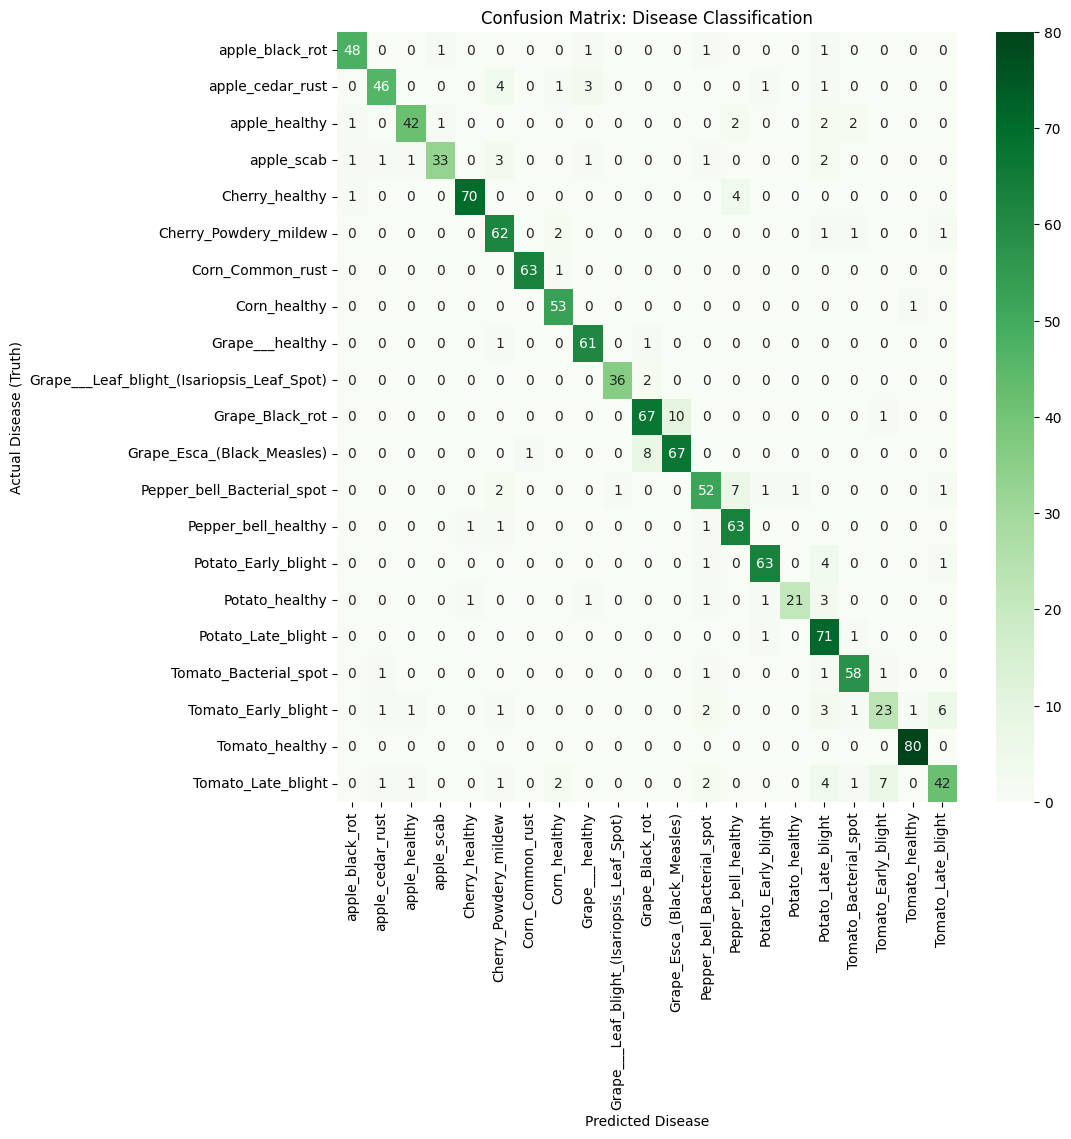

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#using model with best work
y_pred = svm_model.predict(X_test_scaled)

# 2. Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 3. Plotting using Seaborn
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=CATEGORIES,
            yticklabels=CATEGORIES)

plt.xlabel('Predicted Disease')
plt.ylabel('Actual Disease (Truth)')
plt.title('Confusion Matrix: Disease Classification')
plt.show()

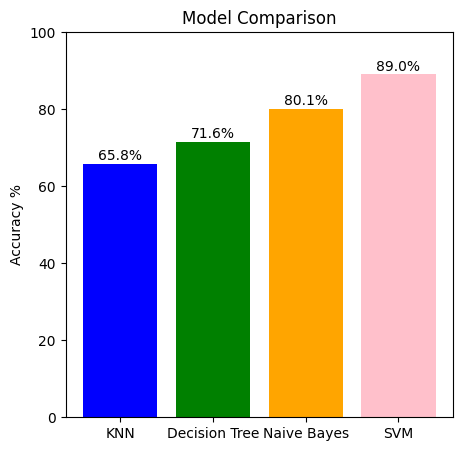

In [12]:
models = ['KNN', 'Decision Tree', 'Naive Bayes', 'SVM']
accuracies = [acc_knn*100, acc_dt*100, acc_nb*100, acc_svm*100]

plt.figure(figsize=(5,5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'pink'])
plt.ylabel('Accuracy %')
plt.title('Model Comparison')
plt.ylim(0, 100)
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.show()

In [13]:
# Knowledge Base: Mapping Disease Categories to Agricultural Advice
TREATMENTS = {
    'apple_black_rot': "Prune infected branches and remove 'mummy' fruit. Use copper-based fungicides.",
    'apple_cedar_rust': "Remove nearby junipers. Apply preventative fungicides like Myclobutanil.",
    'apple_healthy': "Plant is healthy. Maintain regular pruning and monitoring.",
    'apple_scab': "Rake and destroy fallen leaves. Use sulfur sprays in early spring.",
    'Cherry_healthy': "Healthy! Ensure adequate sunlight and well-drained soil.",
    'Cherry_Powdery_mildew': "Increase air circulation. Use potassium bicarbonate or sulfur sprays.",
    'Corn_Common_rust': "Plant resistant hybrids. Fungicides are rarely needed unless severe.",
    'Corn_healthy': "Healthy! Ensure consistent nitrogen levels in soil.",
    'Corn_Northern_Leaf_Blight': "Rotate crops. Apply foliar fungicides if symptoms appear early.",
    'Grape___healthy': "Healthy! Maintain trellis support and regular irrigation.",
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': "Remove infected leaves. Apply copper fungicides after harvest.",
    'Grape_Black_rot': "Remove infected berries. Spray with Captan or Myclobutanil.",
    'Grape_Esca_(Black_Measles)': "Prune during dry weather. Protect large pruning wounds with sealants.",
    'Pepper_bell_Bacterial_spot': "Use copper-mancozeb sprays. Avoid overhead watering.",
    'Pepper_bell_healthy': "Healthy! Monitor for aphids and maintain soil moisture.",
    'Potato_Early_blight': "Use crop rotation. Apply chlorothalonil or copper fungicides.",
    'Potato_healthy': "Healthy! Ensure proper hilling and nutrient balance.",
    'Potato_Late_blight': "🚨 URGENT: Destroy infected tubers. Apply aggressive fungicide schedule.",
    'Tomato_Bacterial_spot': "Use copper-based sprays. Avoid handling plants when wet.",
    'Tomato_Early_blight': "Remove lower leaves to prevent soil splash. Use mulch.",
    'Tomato_healthy': "Healthy! Watch for hornworms and keep leaves dry.",
    'Tomato_Late_blight': "🚨 URGENT: Remove and burn infected plants. Apply Chlorothalonil."
}

In [19]:
import pickle

# 1. Create a dictionary to keep everything organized
model_data = {
    'model': svm_model,
    'categories': CATEGORIES,
    'treatments': TREATMENTS
}

# 2. Save the Model, Categories, and Treatments
with open('leaf_model_pack.pkl', 'wb') as f:
    pickle.dump(model_data, f)

# 3. Save the Scaler (Crucial for HOG/LBP features)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Files saved: leaf_model_pack.pkl and scaler.pkl")

Files saved: leaf_model_pack.pkl and scaler.pkl


In [20]:
# Check if model files exist before loading
if os.path.exists('leaf_model_pack.pkl') and os.path.exists('scaler.pkl'):
    with open('leaf_model_pack.pkl', 'rb') as f:
        model_data = pickle.load(f)
        svm_model = model_data['model']
        CATEGORIES = model_data['categories']
        TREATMENTS = model_data['treatments']

    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    print("Pre-trained model and scaler loaded successfully!")
else:
    print("Model files not found. Please run the training cells first.")

Pre-trained model and scaler loaded successfully!


Using the Best Model: SVM (RBF Kernel) | Accuracy: 89.4%
Upload a leaf image:


Saving bs1.jpg to bs1.jpg


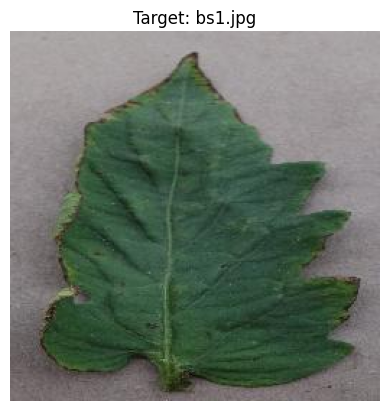

----------------------------------------
PREDICTION: Tomato_Bacterial_spot
RECOMMENDATION: Use copper-based sprays. Avoid handling plants when wet.
----------------------------------------


In [15]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Display model status
print(f"Using the Best Model: SVM (RBF Kernel) | Accuracy: 89.4%")
print("Upload a leaf image:")

uploaded = files.upload()

for fn in uploaded.keys():
    # 1. Load the uploaded image
    img = cv2.imread(fn)
    if img is None:
        print(f"Error: Could not load image {fn}")
        continue

    # 2. Show the image for the user
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Target: {fn}")
    plt.axis('off')
    plt.show()

    # 3. Feature Extraction (HOG, LBP, HSV)
    # This must match the training dimensions (2,286 features)
    img_features = extract_advanced_features(img).reshape(1, -1)

    # 4. Apply the Scaler (MANDATORY)
    # This aligns the live image with the 89.4% accuracy training data
    img_features_scaled = scaler.transform(img_features)

    # 5. Predict the Category
    prediction_index = svm_model.predict(img_features_scaled)[0]
    result = CATEGORIES[prediction_index]

    # 6. Fetch Recommendation (Must happen AFTER prediction)
    recommendation = TREATMENTS.get(result, "No specific treatment found. Consult an expert.")

    # 7. Final Output
    print("-" * 40)
    print(f"PREDICTION: {result}")
    print(f"RECOMMENDATION: {recommendation}")
    print("-" * 40)